<a href="https://colab.research.google.com/github/rhehgus02/ESAA_OB/blob/main/%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%94%A5%EB%9F%AC%EB%8B%9D_%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C(6)_%ED%95%A9%EC%84%B1%EA%B3%B1(4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## **7. 이미지 분할(Segmentation)**

* 이미지 분할 또는 세그멘테이션: 이미지를 구성하는 모든 픽셀에 대해 픽셀 단위로 분류하는 것

    -> 즉, 모든 픽셀은 어떤 클래스에 속함

    -> 예를 들어, 배경 클래스와 객체 클래스로 구성된 이미지가 있다면, 모든 픽셀은 배경 또는 객체 중 하나로 분류됨

    -> 이렇게 모든 픽셀에 대한 정답 클래스를 레이블 처리한 데이터셋을 가지고 딥러닝 모델을 훈련시키면 정답 클래스를 알지 못하는 새로운 이미지에 대해서도 배경과 객체를 분리할 수 있음

* 이미지 분할은 의미 분할과 인스턴스 분할로 구분됨

    * 의미 분할: 같은 범주의 여러 객체를 하나의 범주로 묶어서 구분

    * 인스턴스 분할: 같은 범주에 속하더라도 서로 다른 객체를 구분

---

### **7-1. 데이터셋 준비**

* 이미지 분할 예제에 사용할 데이터셋: Oxford-IIIT Pet Dataset

    -> 이 데이터셋은 반려동물의 이미지 및 분류 레이블, 각 이미지를 구성하는 픽셀 단위의 마스크로 구성되어 있음

    -> 여기서 마스크는 각 픽셀에 대한 범주 레이블을 나타냄

* 각 픽셀은 다음 세 가지 범주 중 하나에 속함

    * class1: 반려동물이 속한 픽셀 (다음 그림의 노란색 영역)
    
    * class2: 반려동물과 인접한 픽셀 (빨간색 영역)
    
    * class3: 위에 속하지 않는 경우/주변 픽셀 (파란색 영역)

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import cv2
from tqdm.notebook import tqdm
import tensorflow_datasets as tfds
from google.colab.patches import cv2_imshow

* 모델 학습에 필요한 입력 이미지의 크기와 학습 파라미터를 설정

    -> 주요 파라미터를 따로 정리하면 모델의 세부 튜닝 작업을 효율적으로 할 수 있음

In [2]:
# 이미지 크기
img_w = 128
img_h = 128
img_c = 3
img_shape = (img_w, img_h, img_c)

# 모델 학습
epoch_num = 5
learning_rate = 0.0001
buffer_size = 1000
batch_size = 16

* 텐서플로 데이터셋에서 옥스포드 반려동물 데이터를 불러옴

    -> 메타 정보를 가져와서 info 변수에 저장

In [3]:
# 텐서플로 데이터셋 로드
ds_str = "oxford_iiit_pet"
ds, info = tfds.load(name = ds_str, with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteXCIQ5J/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteXCIQ5J/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


* 원본 이미지와 분할 마스크를 전처리하는 함수를 정의

    -> 이미지 크기를 사전에 정의한 (128, 128) 크기로 변경하고 자료형을 변환함

    -> 원본 이미지의 픽셀을 255로 나눠서 0~1 범위로 정규화함

    -> 마스크는 0, 1, 2의 정수형 값을 갖도록 1을 차감함


In [4]:
# 이미지 전처리 함수
def preprocess_image(ds):
    # 원본 이미지
    img = tf.image.resize(ds["image"], (img_w, img_h))
    img = tf.cast(img, tf.float32) / 255.0
    # 분할 마스크
    mask = tf.image.resize(ds["segmentation_mask"], (img_w, img_h))
    mask = tf.cast(mask, tf.int32)
    mask = mask - 1
    return img, mask

* 앞에서 정의한 전처리 함수를 훈련 셋, 테스트 셋에 매핑해 주고 미니배치로 분할함

In [5]:
# 데이터 전처리 파이프라인
train_ds = ds["train"].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)
test_ds = ds["test"].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)

print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.int32, name=None))>


In [6]:
# 샘플 배치 선택, 배치에는 16개의 샘플 이미지와 마스크 이미지가 들어 있음
img, mask = next(iter(train_ds))
len(img)

16

* 배치에서 첫 번째 이미지를 출력

    -> 0~1 사이의 값이므로 255를 곱해서 정규화 이전의 원래 값으로 복원

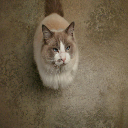

In [7]:
# 샘플 이미지 출력
img = np.array(img[0]) * 255.0
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2_imshow(img)

* 마스크 이미지를 출력

    -> 마스크 값의 범위는 0~2이므로 2로 나눈 다음에 255를 곱하면 RGB 이미지로 표현할 수 있음

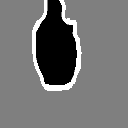

In [8]:
# 샘플 마스크 출력
mask = (np.array(mask[0]) / 2) * 255.0
cv2_imshow(mask)

---

### **7-2. U-Net 모델(인코더-디코더)**

* 사전 학습된 VGG16 모델을 인코더로 활용하는 U-Net 모델을 생성

    -> VGG16은 이미지넷 경진 대회를 통해 성능이 검증된 모델

* 데이터 개수가 충분하고, 시간이 충분하다면 사전 학습된 모델 없이 U-Net을 구성하여 학습을 진행해도 됨

    -> 구글 코랩 환경에서 제한된 자원으로 양호한 성능을 갖는 모델을 만들기 위해서 사전 학습된 모델을 베이스모델로 활용하는 전이 학습 방법을 사용


In [9]:
# VGG16 모델
base_model = tf.keras.applications.VGG16(input_shape = img_shape, include_top = False)

58889256/58889256 [==============================] - 0s 0us/step


* VGG16 모델은 합성곱 층과 풀링 층을 직렬로 연결한 구조를 가짐

    -> 모델 구조를 보면 (128, 128) 크기의 텐서가 마지막 레이어에서는 (4, 4) 크기로 축소되는 것을 확인할 수 있음

* 인코더는 원본 이미지 중에서 같은 범주에 속하는 픽셀을 결합하면서 점진적으로 이미지를 더 작은 크기로 축소함

    -> 마스크 정답을 활용하여 각 픽셀의 마스크 범주를 0, 1, 2 중에서 하나로 분류하는 역할

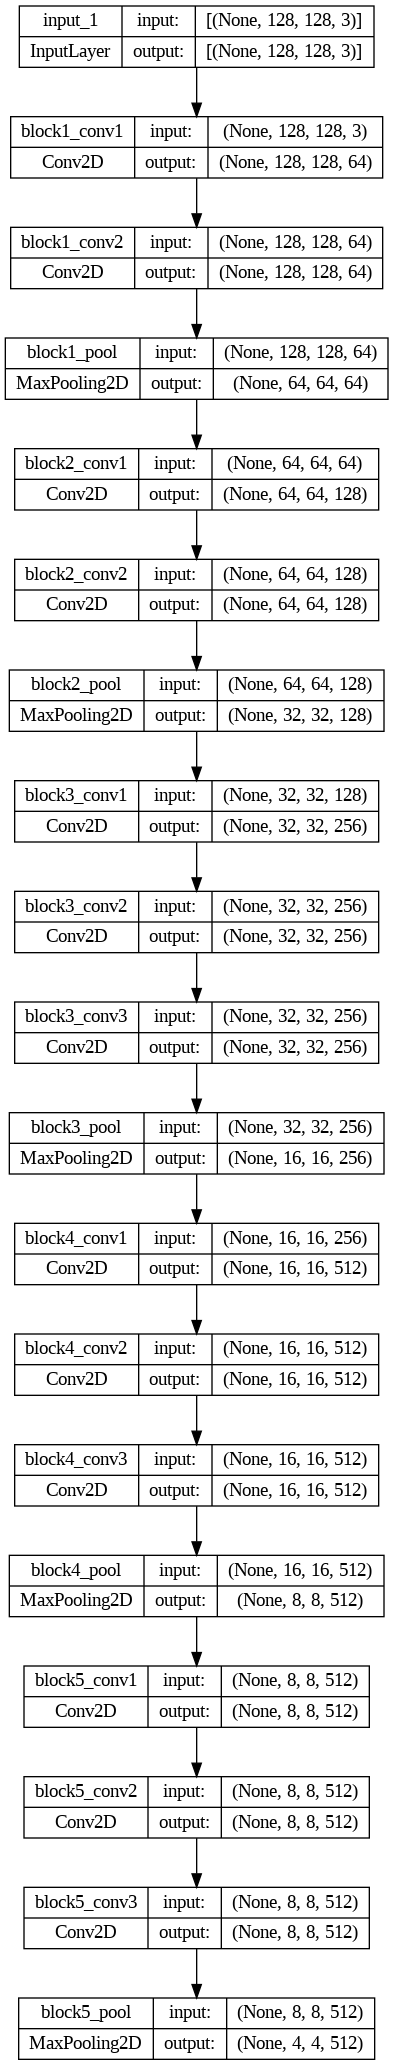

In [10]:
# 모델 구조
tf.keras.utils.plot_model(base_model, show_shapes = True)

* 만들고자 하는 U-net의 모양을 미리 정하고, 사전 학습된 모델에서 어느 부분의 어떤 shape의 출력을 가져올지 먼저 정함

    -> VGG16 모델의 중간 레이어 중에서 필요한 출력 텐서를 지정하여, 다양한 피처를 추출하는 인코더 모델을 정의

* 여기서 VGG16 모델로부터 5개의 출력을 가져와 사용함

    -> 새로운 Feature Extractor 모델을 정의하고, f_model 변수에 저장

    -> 1개의 입력과 5개의 출력을 가짐

In [11]:
# VGG16 중간 레이어 출력 텐서를 지정
f_model = tf.keras.Model(inputs = [base_model.input],
                         outputs = [
                             base_model.get_layer(name = "block5_conv3").output,
                             base_model.get_layer(name = "block4_conv3").output,
                             base_model.get_layer(name = "block3_conv3").output,
                             base_model.get_layer(name = "block2_conv2").output,
                             base_model.get_layer(name = "block1_conv2").output,
                         ])

* 사전 학습된 파라미터를 인코더에 그대로 사용하기 위해서 업데이트되지 않도록 고정함

In [12]:
# 파라미터 고정
f_model.trainable = False

* 업샘플링: 축소된 이미지를 원래 이미지 크기로 복원하는 과정

    -> 인코더 부분에서 5개의 출력을 가져와서 디코더의 입력으로 전달하면서 업샘플링을 함

    -> 제일 작은 (8, 8, 512) 텐서에서 시작해서 조금씩 크기를 키워 나가며 중간 출력과 합침

In [13]:
# U-Net 구조로 모델 정의

i = tf.keras.Input(shape = img_shape)

out_8_8_512, out_16_16_512, out_32_32_256, out_64_64_128, out_128_128_64 = f_model(i)

out = tf.keras.layers.Conv2DTranspose(512, 3, strides = 2, padding = "same")(out_8_8_512)
out = tf.keras.layers.Add()([out, out_16_16_512])

out = tf.keras.layers.Conv2DTranspose(256, 3, strides = 2, padding = "same")(out)
out = tf.keras.layers.Add()([out, out_32_32_256])

out = tf.keras.layers.Conv2DTranspose(128, 3, strides = 2, padding = "same")(out)
out = tf.keras.layers.Add()([out, out_64_64_128])

out = tf.keras.layers.Conv2DTranspose(64, 3, strides = 2, padding = "same")(out)
out = tf.keras.layers.Add()([out, out_128_128_64])

out = tf.keras.layers.Conv2DTranspose(3, 3, activation = "elu", padding = "same")(out)
out = tf.keras.layers.Dense(3, activation = "softmax")(out)

unet_model = tf.keras.Model(inputs = [i], outputs = [out])

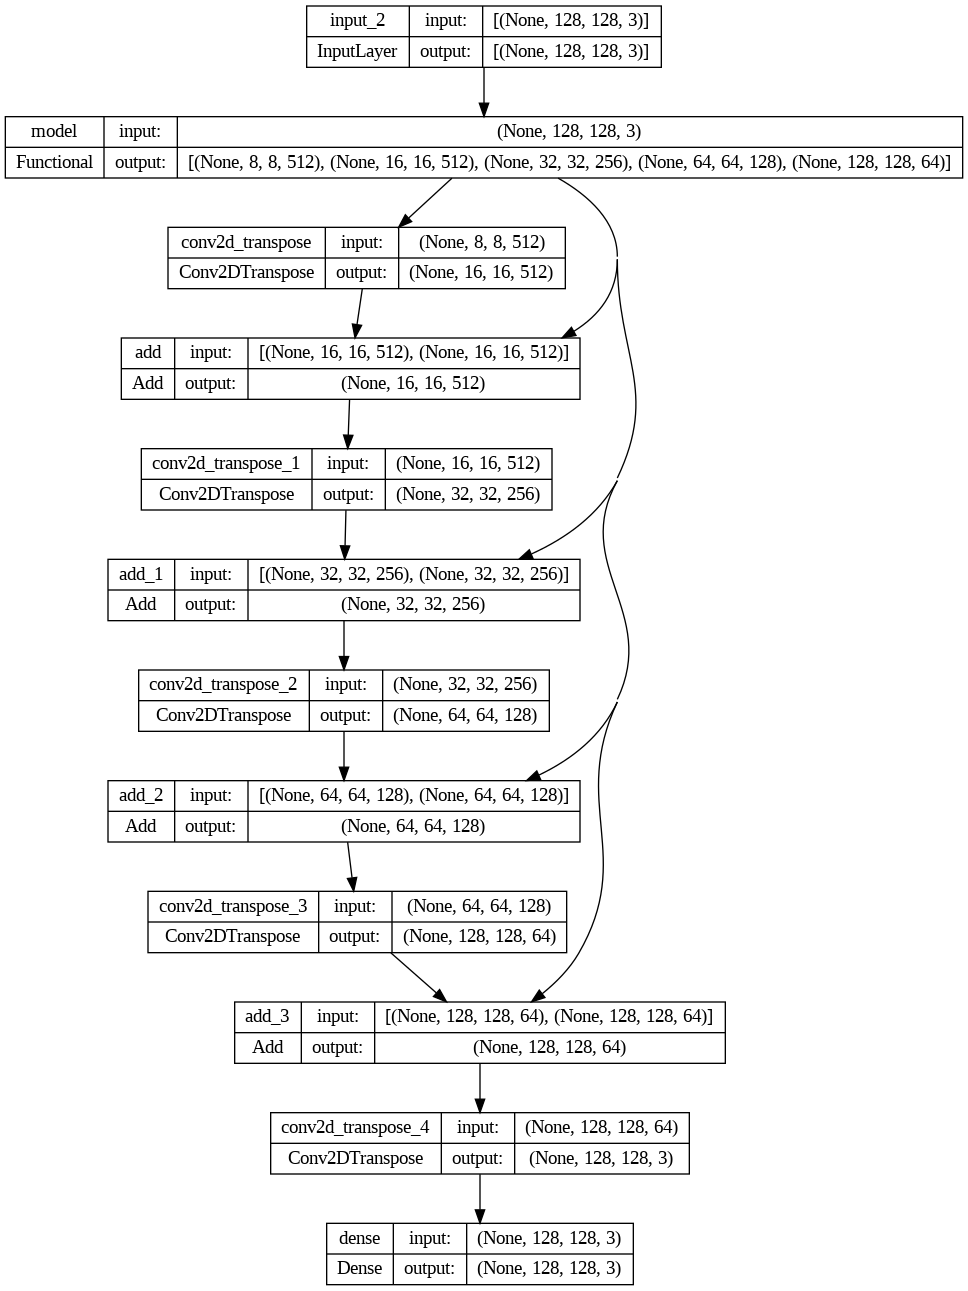

In [14]:
# 모델 구조 시각화
tf.keras.utils.plot_model(unet_model, show_shapes = True)

>> 인코더의 중간 출력이 업샘플링 과정에서 디코더의 중간 출력과 합쳐지는 것을 확인할 수 있음

In [15]:
# 모델 요약
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model (Functional)          [(None, 8, 8, 512),          1471468   ['input_2[0][0]']             
                              (None, 16, 16, 512),        8                                       
                              (None, 32, 32, 256),                                                
                              (None, 64, 64, 128),                                                
                              (None, 128, 128, 64)]                                               
                                                                                            

>> f_model로부터 유래하는 5개 레이어의 14,714,688개의 파라미터는 학습되지 않도록 고정돼 있음

* 예측 클래스 개수가 3개인 다중 분류 문제에 맞도록 SparseCategoricalCrossentropy 손실함수를 설정하고, Adam 옵티마이저를 적용

In [ ]:
# 모델 컴파일 및 훈련
loss_f = tf.losses.SparseCategoricalCrossentropy()
opt = tf.optimizers.Adam(learning_rate)

unet_model.compile(optimizer = opt, loss = loss_f, metrics = ["accuracy"])
unet_model.fit(train_ds, batch_size = batch_size, epochs = epoch_num)

Epoch 1/5
230/230 [==============================] - 1335s 6s/step - loss: 1.0051 - accuracy: 0.5780
Epoch 2/5
230/230 [==============================] - 1298s 6s/step - loss: 0.6809 - accuracy: 0.8031
Epoch 3/5
173/230 [=====================>........] - ETA: 5:22 - loss: 0.5680 - accuracy: 0.8213

* 검증 셋의 배치를 하나 선택하고 `predict()` 메소드로 이미지 분할 클래스를 예측

1/1 [==============================] - 7s 7s/step


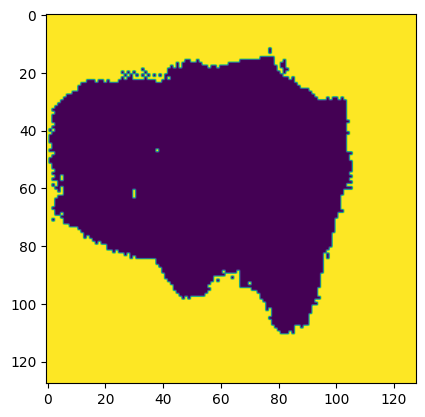

In [17]:
# 1개 배치(16개 이미지)를 선택
img, mask = next(iter(test_ds))

# 모델 예측
pred = unet_model.predict(img)

# 첫 번째 이미지 분할 결과를 출력
pred_img = np.argmax(pred[0], -1)
plt.imshow(pred_img)

* 정답 마스크 이미지를 출력하고, 앞서 예측한 분할 이미지와 비교

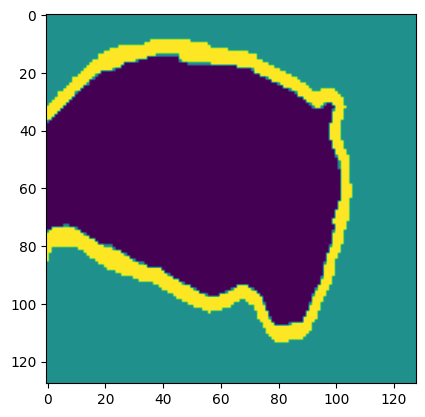

In [18]:
# 첫 번째 이미지의 정답 마스크 출력
plt.imshow(np.reshape(mask[0], (128, 128)))

>> 어느 정도 객체의 경계를 찾아내는 것을 확인할 수 있음